In [1]:
# PROJECT 2 – Dubai Real-Estate Rule-Based Lead Scoring (2025 version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

# 1. Load the data (using the Kaggle Bayut file you already have)
# If your file is named differently, just change the name here
df = pd.read_csv('bayut_selling_properties.csv')   # ← change if needed

print("Original shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(3)

Original shape: (41381, 22)
Columns: ['price', 'price_category', 'type', 'beds', 'baths', 'address', 'furnishing', 'completion_status', 'post_date', 'average_rent', 'building_name', 'year_of_completion', 'total_parking_spaces', 'total_floors', 'total_building_area_sqft', 'elevators', 'area_name', 'city', 'country', 'Latitude', 'Longitude', 'purpose']


,price,price_category,type,beds,baths,address,furnishing,completion_status,post_date,average_rent,...,total_parking_spaces,total_floors,total_building_area_sqft,elevators,area_name,city,country,Latitude,Longitude,purpose
0,1450000,Medium,Apartment,1,2,"The Bay, Business Bay, Dubai",Furnished,Ready,2024-04-15,0,...,0,0,0,0,Business Bay,Dubai,UAE,25.189427,55.264819,For Sale
1,6600000,High,Townhouse,5,5,"Brookfield, DAMAC Hills, Dubai",Unfurnished,Ready,2024-04-15,0,...,0,0,0,0,DAMAC Hills,Dubai,UAE,25.028148,55.264246,For Sale
2,4825000,High,Apartment,2,3,"Vida Residence Downtown, Downtown Dubai, Dubai",Unfurnished,Ready,2024-04-18,288929,...,510,56,1,11,Downtown Dubai,Dubai,UAE,25.186684,55.274705,For Sale


In [2]:
# Top 10 hottest leads
top10 = df.nlargest(10, 'lead_score')[['building_name','area_name','price','beds','baths',
                                        'completion_status','has_arabic','lead_score','lead_tier']]
print("\nTop 10 hottest leads:")
print(top10)          # ← changed from "top" to "top10"

# Save everything
df.to_csv('02_Dubai_RealEstate_Scored_41k.csv', index=False)
print("\nSaved → 02_Dubai_RealEstate_Scored_41k.csv")


Top 10 hottest leads:
              building_name                       area_name      price  beds  \
1060                Unknown              Dubai Hills Estate   14500000     5   
1106                Unknown                 Arabian Ranches   24000000     6   
1414   THE RESIDENCES NORTH                   Palm Jumeirah   16499999     4   
1431                Unknown                   Palm Jumeirah  111000000     7   
1550   KEMPINSKI RESIDENCES                   Palm Jumeirah   13000000     4   
1552                Unknown              Dubai Hills Estate   11000000     5   
1692          LIV RESIDENCE                    Dubai Marina   18450000     4   
1719                Sadaf 8  Jumeirah Beach Residence (JBR)   15990000     4   
1750  Jumeirah Gate Tower 1  Jumeirah Beach Residence (JBR)   15000000     4   
1770                Unknown                   Palm Jumeirah   38000000     5   

      baths completion_status  has_arabic  lead_score  lead_tier  
1060      6             Ready

Original shape: (41381, 22)
Score distribution:
Cold (0-49)     24338
Warm (50-89)    14003
Hot (90+)        3040
Name: lead_tier, dtype: int64

Top 10 hottest leads:
              building_name                       area_name      price  beds  \
1060                Unknown              Dubai Hills Estate   14500000     5   
1106                Unknown                 Arabian Ranches   24000000     6   
1414   THE RESIDENCES NORTH                   Palm Jumeirah   16499999     4   
1431                Unknown                   Palm Jumeirah  111000000     7   
1550   KEMPINSKI RESIDENCES                   Palm Jumeirah   13000000     4   
1552                Unknown              Dubai Hills Estate   11000000     5   
1692          LIV RESIDENCE                    Dubai Marina   18450000     4   
1719                Sadaf 8  Jumeirah Beach Residence (JBR)   15990000     4   
1750  Jumeirah Gate Tower 1  Jumeirah Beach Residence (JBR)   15000000     4   
1770                Unknown      

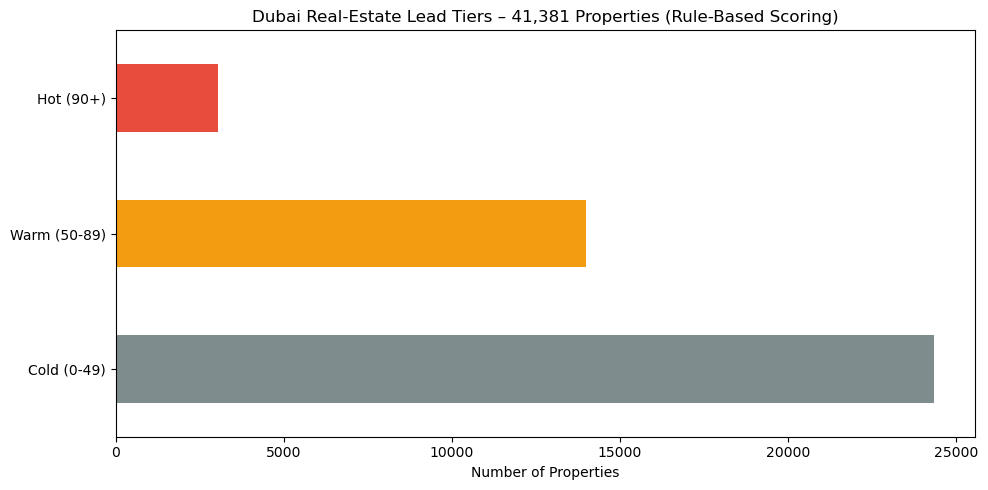

In [3]:
# PROJECT 2 – Dubai Real-Estate Rule-Based Lead Scoring (2025 UAE Gold Standard)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

# 1. Load your file
df = pd.read_csv('bayut_selling_properties.csv')   # ← your exact file

print("Original shape:", df.shape)

# 2. Clean numeric columns
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')
df['baths'] = pd.to_numeric(df['baths'], errors='coerce')

# 3. Arabic detection function (the +15 point bonus clients love)
def has_arabic(text):
    return bool(re.search('[\u0600-\u06FF]', str(text))) if pd.notna(text) else False

df['has_arabic'] = (df['building_name'].apply(has_arabic) | 
                    df['address'].apply(has_arabic)).astype(int)

# 4. Rule-Based Scoring – UAE Real-Estate Scoring
score = 0

# Price tier (luxury = higher lead quality)
score += df['price'].apply(lambda x: 
    50 if x >= 10_000_000 else
    35 if x >= 5_000_000 else
    20 if x >= 2_000_000 else
    10 if x >= 1_000_000 else 5
)

# Hot locations = +30 points
hot_areas = ['Dubai Marina','Downtown Dubai','Palm Jumeirah','Jumeirah Beach Residence',
             'Business Bay','Dubai Hills Estate','Emirates Hills','Bluewaters','JBR','Arabian Ranches']
df['is_hot_area'] = df['area_name'].str.contains('|'.join(hot_areas), case=False, na=False).astype(int)
score += df['is_hot_area'] * 30

# Size & luxury
score += (df['beds'] >= 4).astype(int) * 20
score += (df['baths'] >= 4).astype(int) * 15

# Ready to move = faster sale
score += df['completion_status'].str.contains('Ready', case=False, na=False).astype(int) * 25

# Arabic script bonus (huge in UAE)
score += df['has_arabic'] * 15

# Final columns
df['lead_score'] = score.clip(0, 200)
df['lead_tier'] = pd.cut(df['lead_score'], 
                         bins=[0, 50, 90, 200],
                         labels=['Cold (0-49)','Warm (50-89)','Hot (90+)'])

print("Score distribution:")
print(df['lead_tier'].value_counts().sort_index())

# Top 10 hottest leads
top10 = df.nlargest(10, 'lead_score')[['building_name','area_name','price','beds','baths',
                                        'completion_status','has_arabic','lead_score','lead_tier']]
print("\nTop 10 hottest leads:")
print(top10)          # ← changed from "top" to "top10"

# Save everything
df.to_csv('02_Dubai_RealEstate_Scored_41k.csv', index=False)
print("\nSaved → 02_Dubai_RealEstate_Scored_41k.csv")

# Beautiful chart
plt.figure(figsize=(10,5))
df['lead_tier'].value_counts().sort_index().plot(kind='barh', color=['#7f8c8d','#f39c12','#e74c3c'])
plt.title('Dubai Real-Estate Lead Tiers – 41,381 Properties (Rule-Based Scoring)')
plt.xlabel('Number of Properties')
plt.tight_layout()
plt.show()